In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:
<!-- 1. Add kinematic visocisty -->
<!-- 2. Backport velocity diffusion to DFSPH code (own module) -->
3. IMPROVE PERFORMANCE
4. Add drag forces
5. delta sph with boundary integrals?!
6. setup dambreak with obstacle
7. setup flow past cylinder
8. add wcsph (müller)
9. add compressible sph
10. setup shockwave scenario for compressible sph

In [3]:
# from src.deltaSPH import deltaSPHSimulation

In [4]:
from src.deltaSPH import deltaSPHSimulation
from src.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

In [5]:
velocities = []

r = 2
for i in range(8):
#     for j in range(8):
    theta_i = 2 * np.pi * i / 8
    xi = r * np.cos(theta_i)
    yi = r * np.sin(theta_i)
    
    velocities.append(np.array([xi,yi]))
    
#     debugPrint(xi)
debugPrint(velocities)

velocities [list] = [array([2., 0.]), array([1.41421356, 1.41421356]), array([1.2246468e-16, 2.0000000e+00]), array([-1.41421356,  1.41421356]), array([-2.0000000e+00,  2.4492936e-16]), array([-1.41421356, -1.41421356]), array([-3.6739404e-16, -2.0000000e+00]), array([ 1.41421356, -1.41421356])]


<IPython.core.display.Javascript object>


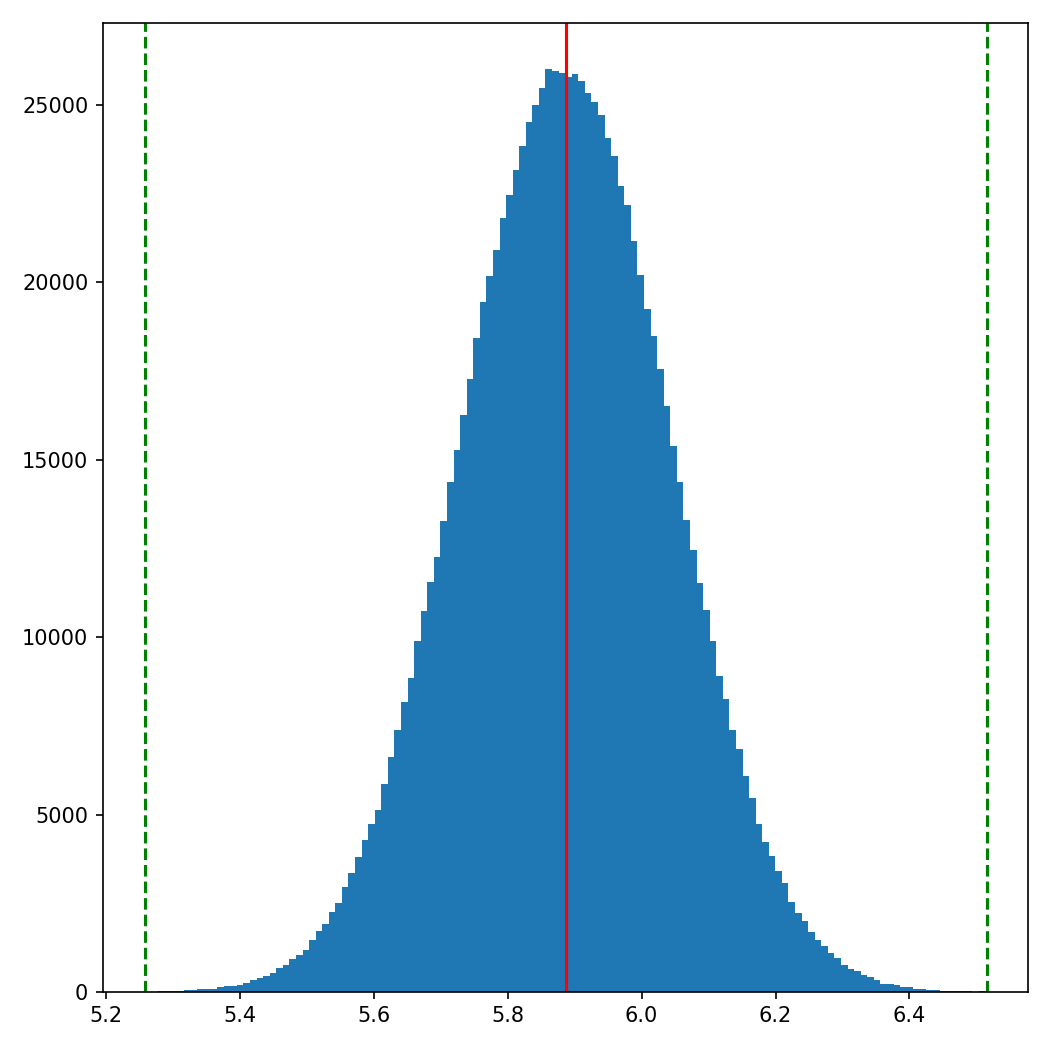

In [8]:

fig, axis = plt.subplots(1, 1, figsize=(7,7 ), sharex = False, sharey = False, squeeze = False)

std = theta1 / 4
a, b = -theta1 / std, theta1 / std
samples = truncnorm.rvs(a, b, loc = theta, scale = std, size = 2**20)

axis[0,0].hist(samples,bins = 128)
axis[0,0].axvline(theta, c = 'red')
axis[0,0].axvline(theta - theta1, c = 'green', ls = '--')
axis[0,0].axvline(theta + theta1, c = 'green', ls = '--')
fig.tight_layout()

In [163]:

print(initialConditions)

[(6.13355530529514, array([ 0.42025118, -0.06335572]), array([ 0.42429736, -0.02442845]), 1), (2.9115372129373265, array([-0.41380285,  0.09691339]), array([-0.41465568,  0.09319692]), 1), (3.986241016437893, array([-0.28219756, -0.31778851]), array([-0.1989594 , -0.37555314]), 1), (4.8869419264592455, array([ 0.07380886, -0.41854182]), array([ 0.28754659, -0.3129568 ]), 1), (5.403737826642796, array([ 0.27097018, -0.32741436]), array([ 0.20159444, -0.37414527]), 1), (2.271121104037877, array([-0.27389807,  0.32496899]), array([-0.34826041,  0.24359739]), 1), (1.3606995929297627, array([0.08863567, 0.41565457]), array([0.0809324, 0.4172229]), 1), (4.429837132487829, array([-0.11849307, -0.40814751]), array([-0.16882239, -0.39003077]), 1), (3.4027863180265294, array([-0.41058503, -0.10974941]), array([-0.3830034, -0.1842102]), 1), (6.152187875723974, array([ 0.42135864, -0.05551481]), array([ 0.39496375, -0.15693513]), 1), (5.46087463388849, array([ 0.28922523, -0.31140611]), array([ 0.

In [7]:
from scipy.stats import truncnorm
r = 0.425
r1 = 0.25
r2 = 0.125
timesteps = 128

thetas = np.random.rand(68) * 2 * np.pi

initialConditions = []

for theta in thetas:
    p1 = np.array([0,0])
    p2 = np.array([np.cos(theta) * r, np.sin(theta) * r])
    dir2 = np.copy(p2)
    orth2 = np.array([-dir2[1],dir2[0]]) / np.linalg.norm(dir2)

    theta1 = np.arcsin(r1 / r)
    theta2 = np.arcsin(-r1 / r)
    p2l = np.array([np.cos(theta + theta1) * r, np.sin(theta + theta1) * r])
    p2r = np.array([np.cos(theta + theta2) * r, np.sin(theta + theta2) * r])

    std = theta1 / 2
    a, b = -theta1 / std, theta1 / std
    theta = truncnorm.rvs(a, b, loc = theta, scale = std, size = 1)[0]
    p2 = np.array([np.cos(theta) * r, np.sin(theta) * r])
    initialConditions.append((theta, p2, dir2, np.sqrt(2)))
    
    
for theta, p2, dir2, vel2 in tqdm(initialConditions):
    config = 'configs/colgen_dfsph.toml'

    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)

    parsedConfig['emitter']['fluidL']['min'] = [-r1, -r1]
    parsedConfig['emitter']['fluidL']['max'] = [r1, r1] 
    parsedConfig['emitter']['fluidL']['velocity'] = [0,0]

    parsedConfig['emitter']['fluidR']['min'] = (p2 - r2).tolist() 
    parsedConfig['emitter']['fluidR']['max'] = (p2 + r2).tolist() 
    parsedConfig['emitter']['fluidR']['velocity'] = (-dir2 * vel2).tolist()
    
    parsedConfig['export']['active'] = True

    simulationModel = dfsphSimulation
    sphSimulation = simulationModel(parsedConfig)
    sphSimulation.initializeSimulation()

    for i in tqdm(range(timesteps), leave = False):
        sphSimulation.integrate()
        
    sphSimulation.outFile.close()

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


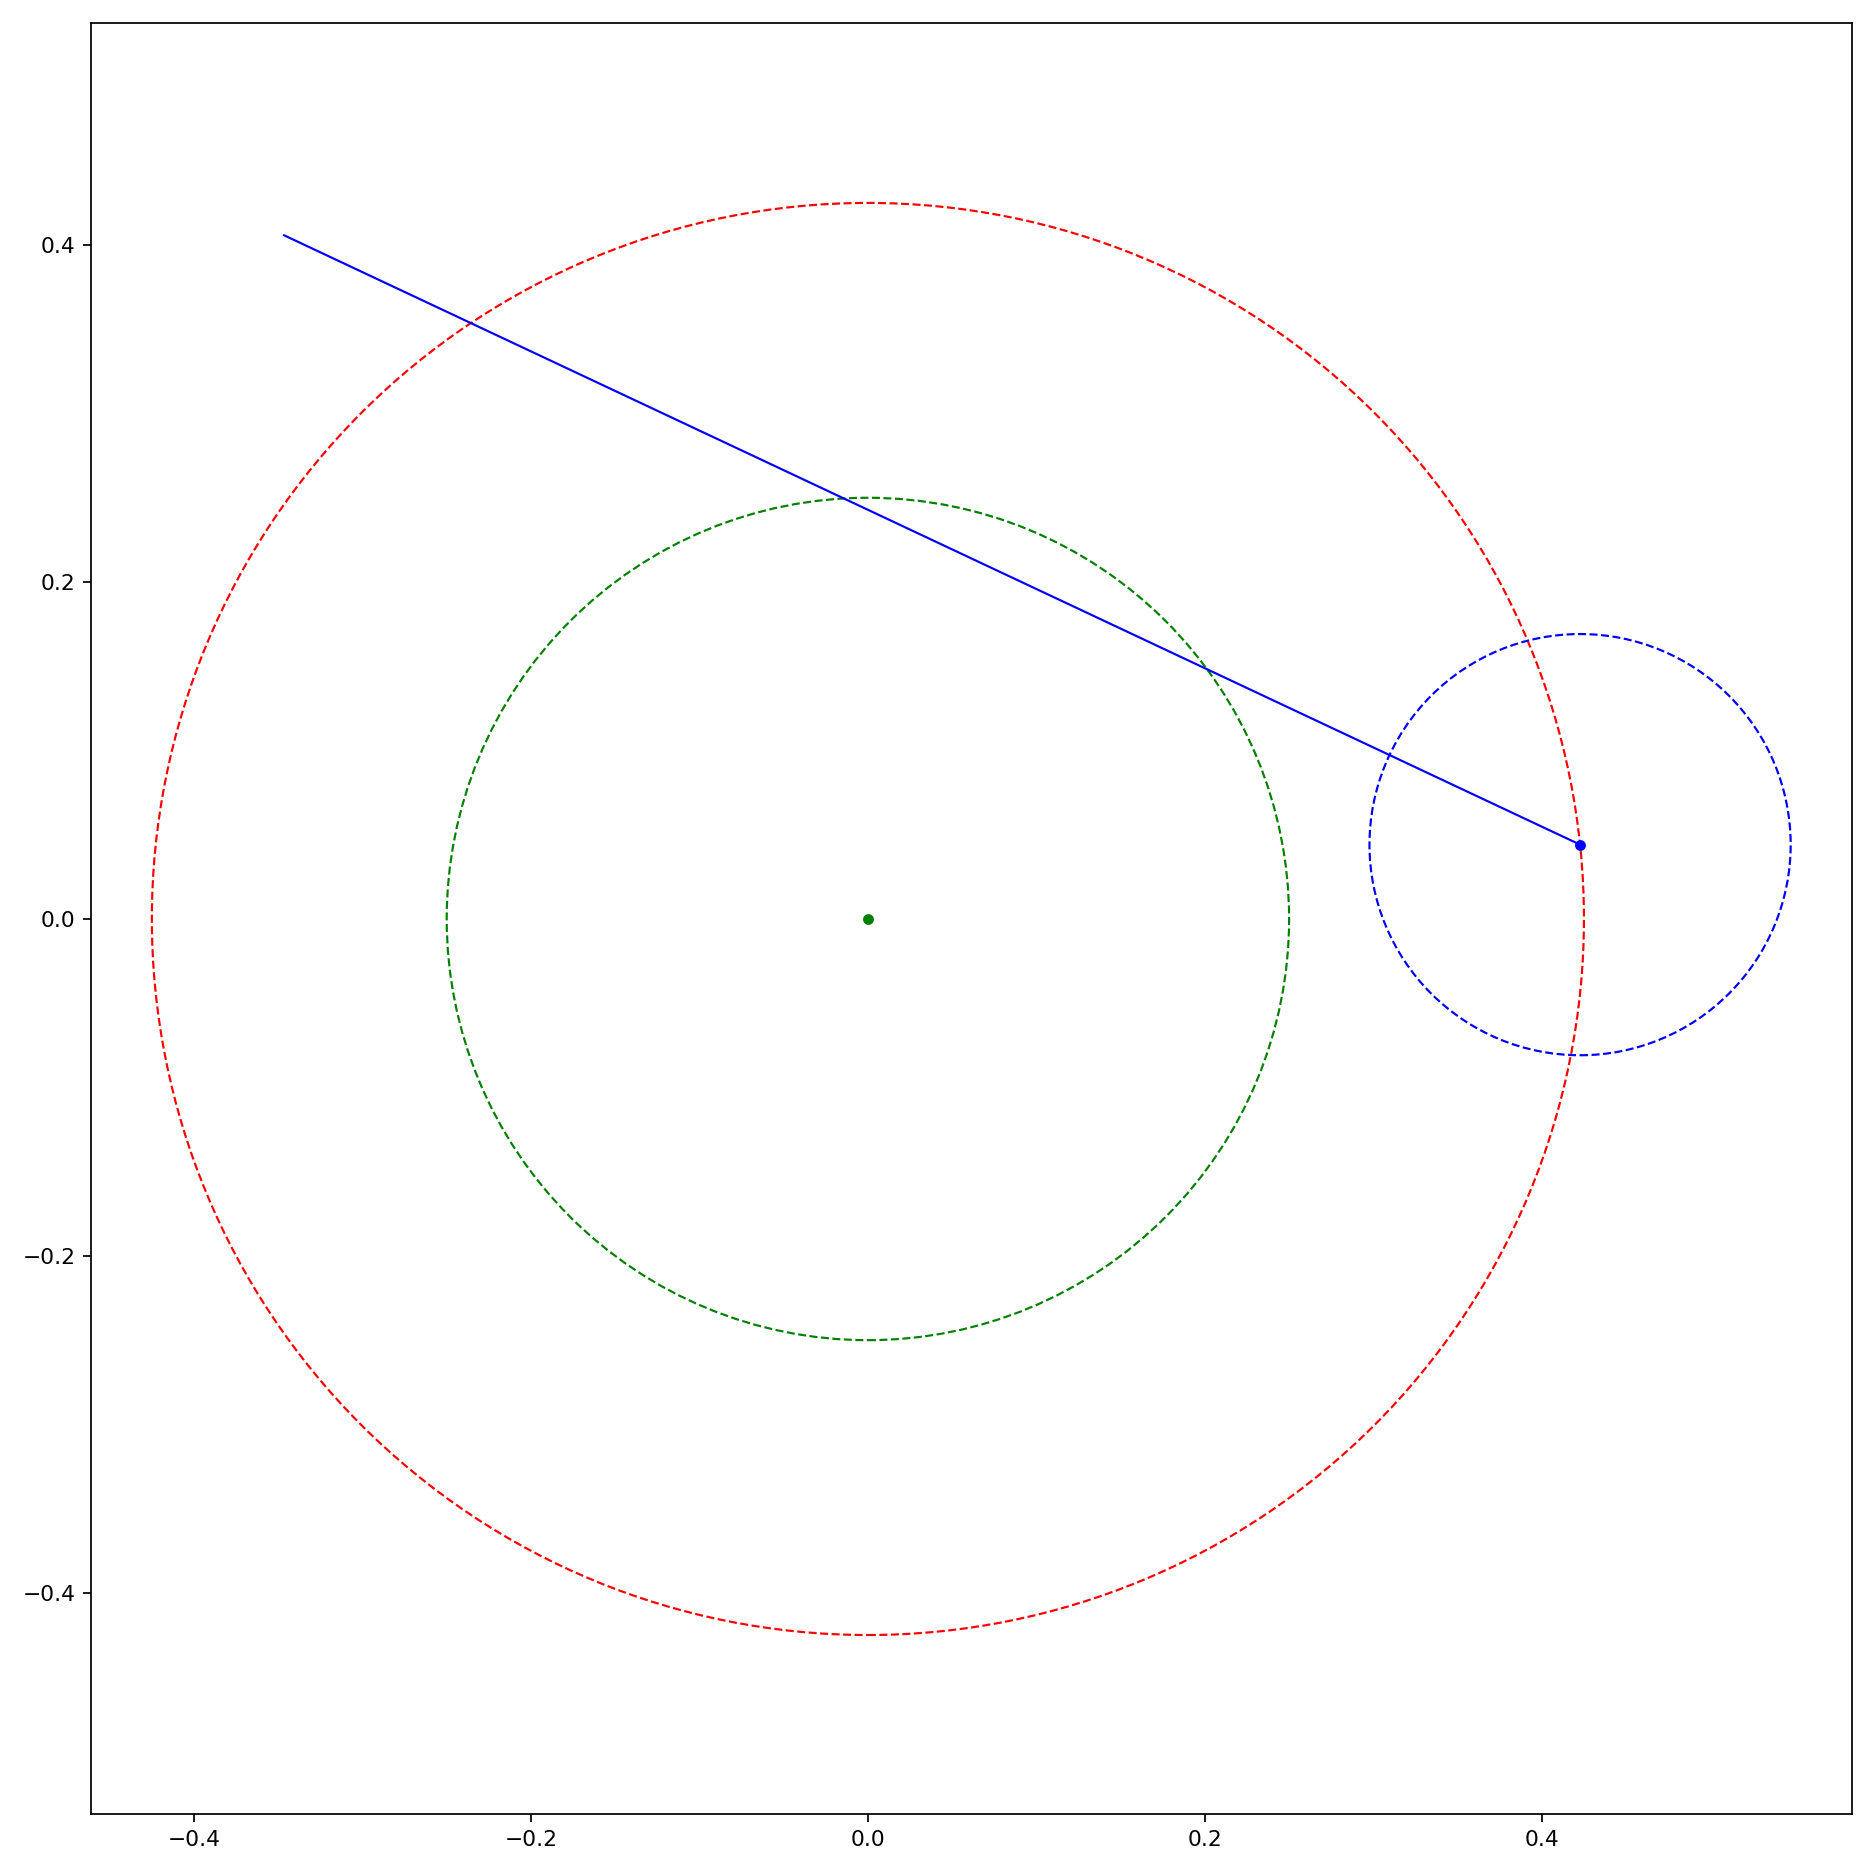

In [77]:
fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)

r = 0.425
r1 = 0.25
r2 = 0.125
theta = np.random.rand() * 2 * np.pi
# theta = np.pi / 4

p1 = np.array([0,0])
p2 = np.array([np.cos(theta) * r, np.sin(theta) * r])
dir2 = np.copy(p2)
orth2 = np.array([-dir2[1],dir2[0]]) / np.linalg.norm(dir2)


theta1 = np.arcsin(r1 / r)
theta2 = np.arcsin(-r1 / r)
p2l = np.array([np.cos(theta + theta1) * r, np.sin(theta + theta1) * r])
p2r = np.array([np.cos(theta + theta2) * r, np.sin(theta + theta2) * r])
axis[0,0].scatter(p2l[0], p2l[1], c = 'red', s = 16)
axis[0,0].scatter(p2r[0], p2r[1], c = 'red', s = 16)

# p2 = p2l
from scipy.stats import truncnorm


std = theta1 / 2
a, b = -theta1 / std, theta1 / std
theta = truncnorm.rvs(a, b, loc = theta, scale = std, size = 1)[0]

p2 = np.array([np.cos(theta) * r, np.sin(theta) * r])


# p2 += orth2 * (np.random.rand() * 2 * r1 - r1)

axis[0,0].cla()
circle1 = plt.Circle((0, 0), r, color='r',ls='--', fill=False)
circle2 = plt.Circle((p1[0], p1[1]), r1, color='green',ls='--', fill=False)
circle3 = plt.Circle((p2[0], p2[1]), r2, color='blue',ls='--', fill=False)

axis[0,0].add_patch(circle1)
axis[0,0].add_patch(circle2)
axis[0,0].add_patch(circle3)

line2 = lambda x: p2[:] + x[:,None] * -dir2[:]
l2 = line2(np.linspace(0,2,256))

axis[0,0].set_xlim(-1.5, 1.5)
axis[0,0].set_ylim(-1.5, 1.5)
axis[0,0].axis('equal')

axis[0,0].scatter(p1[0], p1[1], c = 'green', s = 16)
axis[0,0].scatter(p2[0], p2[1], c = 'blue', s = 16)

axis[0,0].plot(l2[:,0], l2[:,1], c = 'blue', ls = '-', lw = 1)
# print(l2)
fig.tight_layout()

In [167]:
# cis1 = is1 - (is2 + is1) / 2
# cis2 = is2 - (is2 + is1) / 2
config = 'configs/colgen_dfsph.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

parsedConfig['emitter']['fluidL']['min'] = [-r1, -r1]
parsedConfig['emitter']['fluidL']['max'] = [r1, r1] 
parsedConfig['emitter']['fluidL']['velocity'] = [0,0]

vel2 = np.sqrt(2)

parsedConfig['emitter']['fluidR']['min'] = (p2 - r2).tolist() 
parsedConfig['emitter']['fluidR']['max'] = (p2 + r2).tolist() 
parsedConfig['emitter']['fluidR']['velocity'] = (-dir2 * vel2).tolist()

# print(parsedConfig['emitter']['fluidR']['min'])
# print(parsedConfig['emitter']['fluidR']['max'])

simulationModel = dfsphSimulation

In [168]:
sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()

<IPython.core.display.Javascript object>


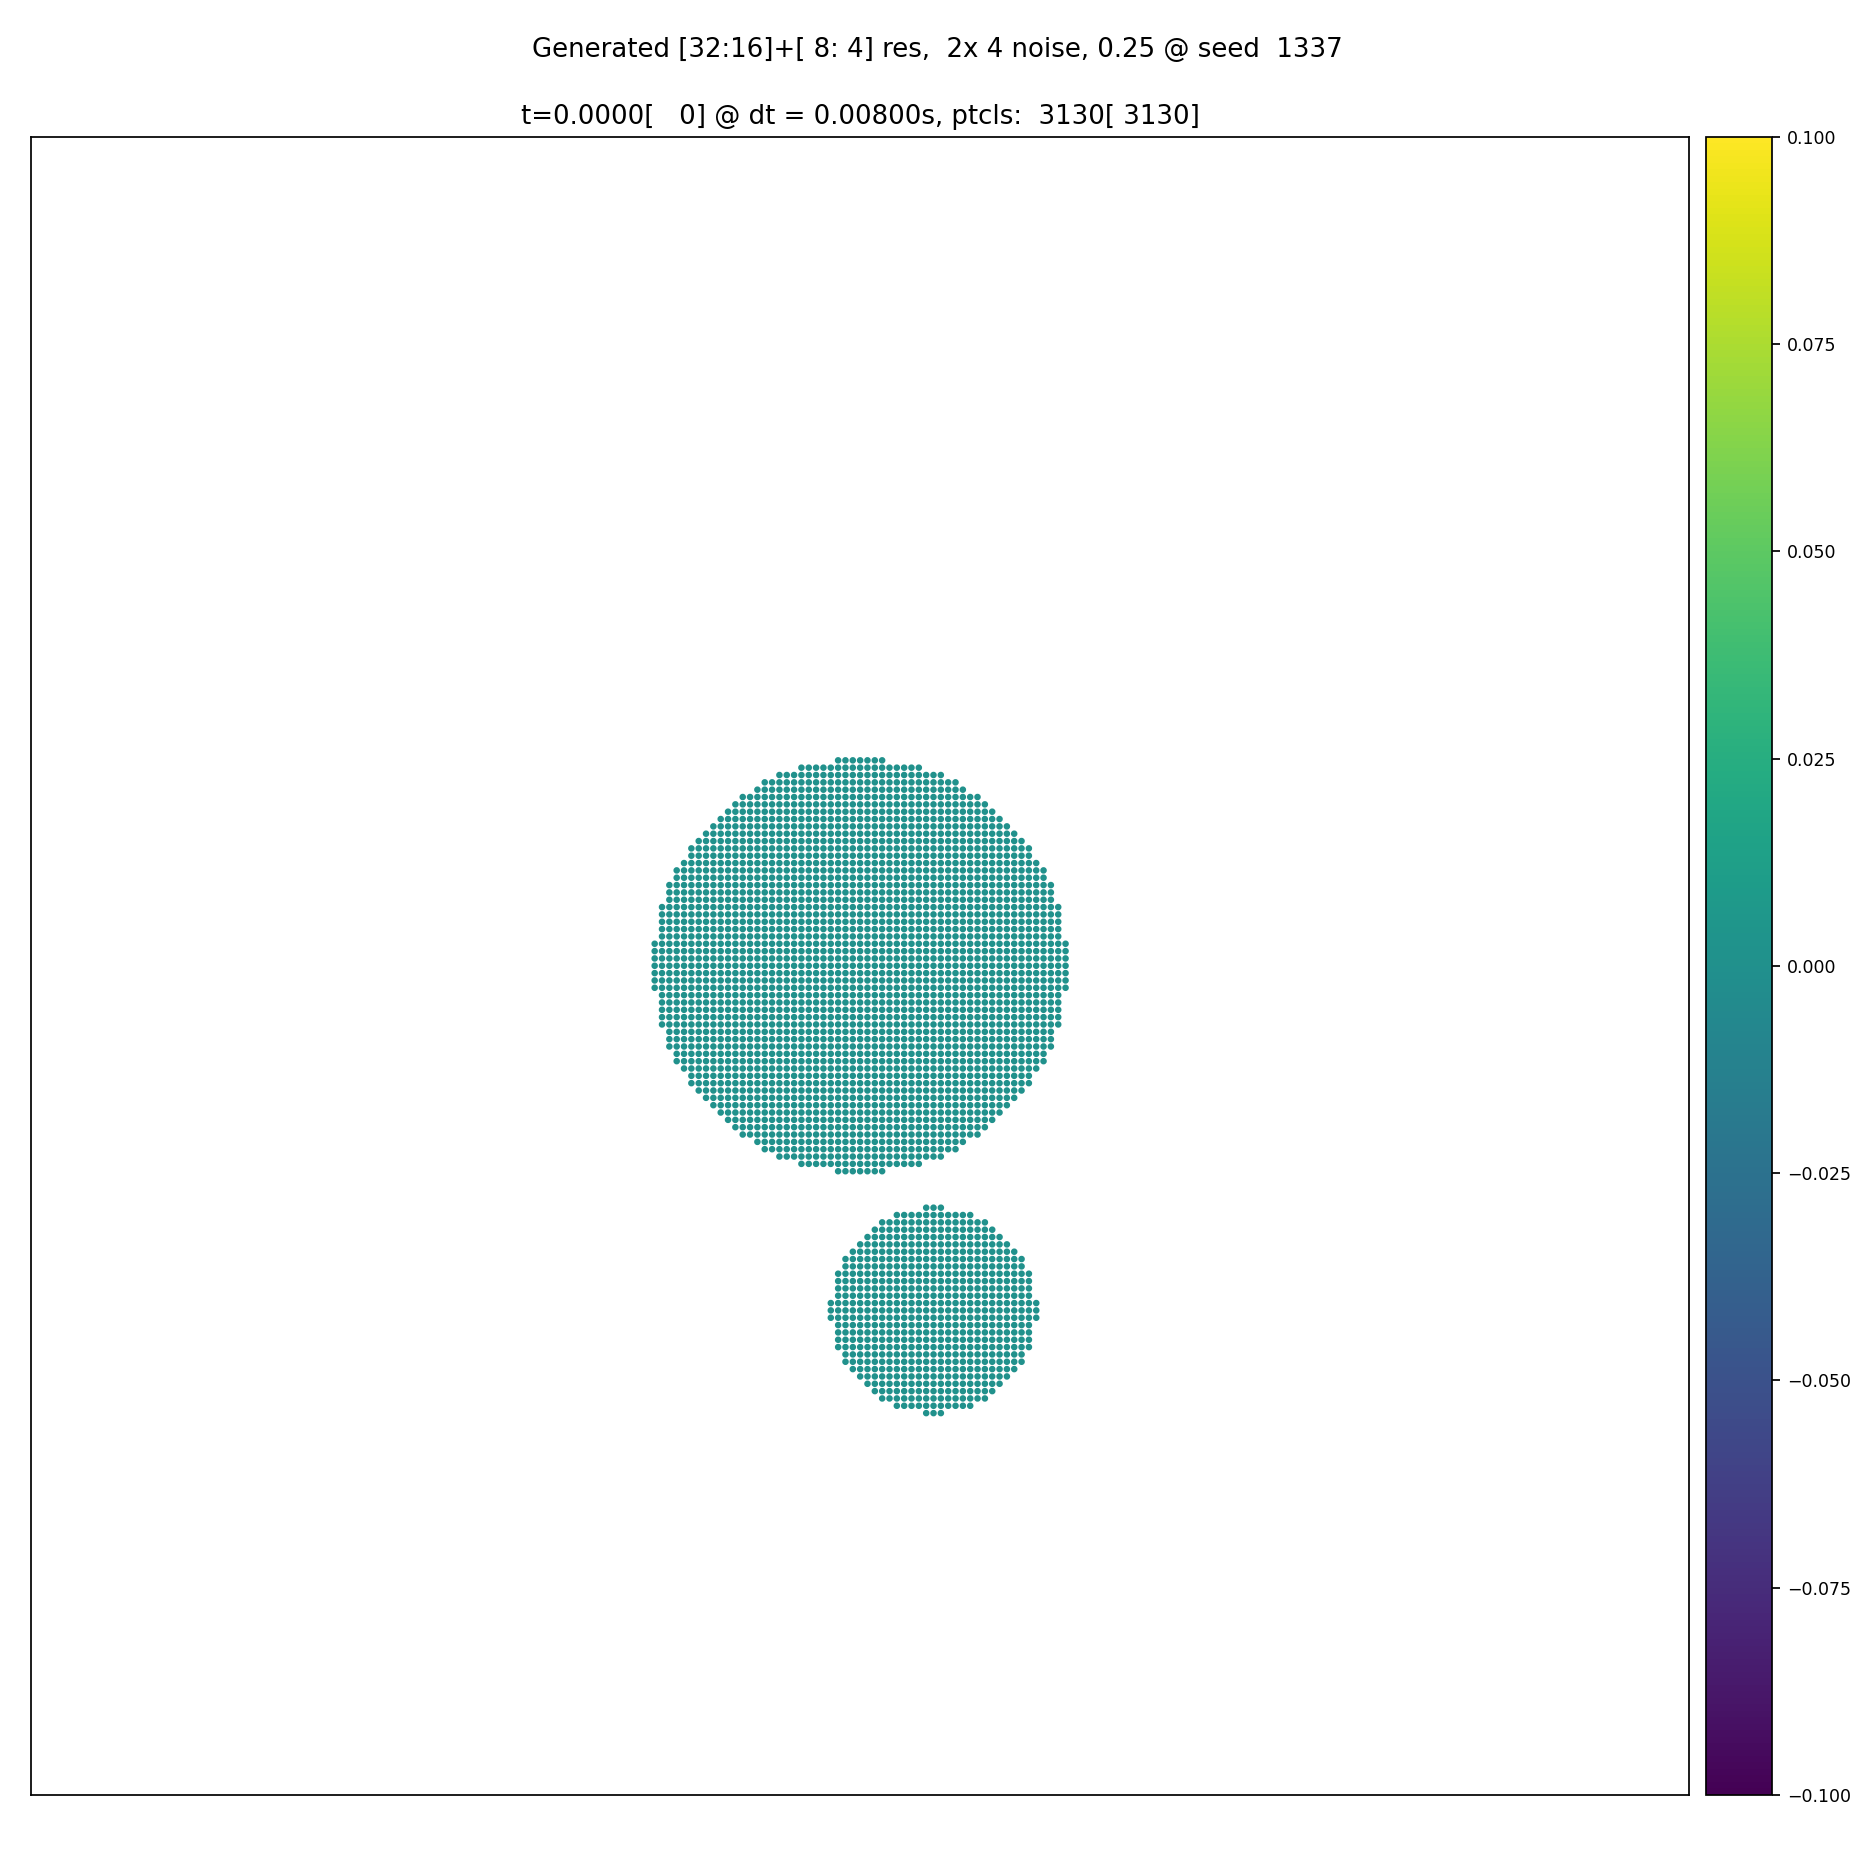

In [169]:
fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidPressure'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()



<IPython.core.display.Javascript object>


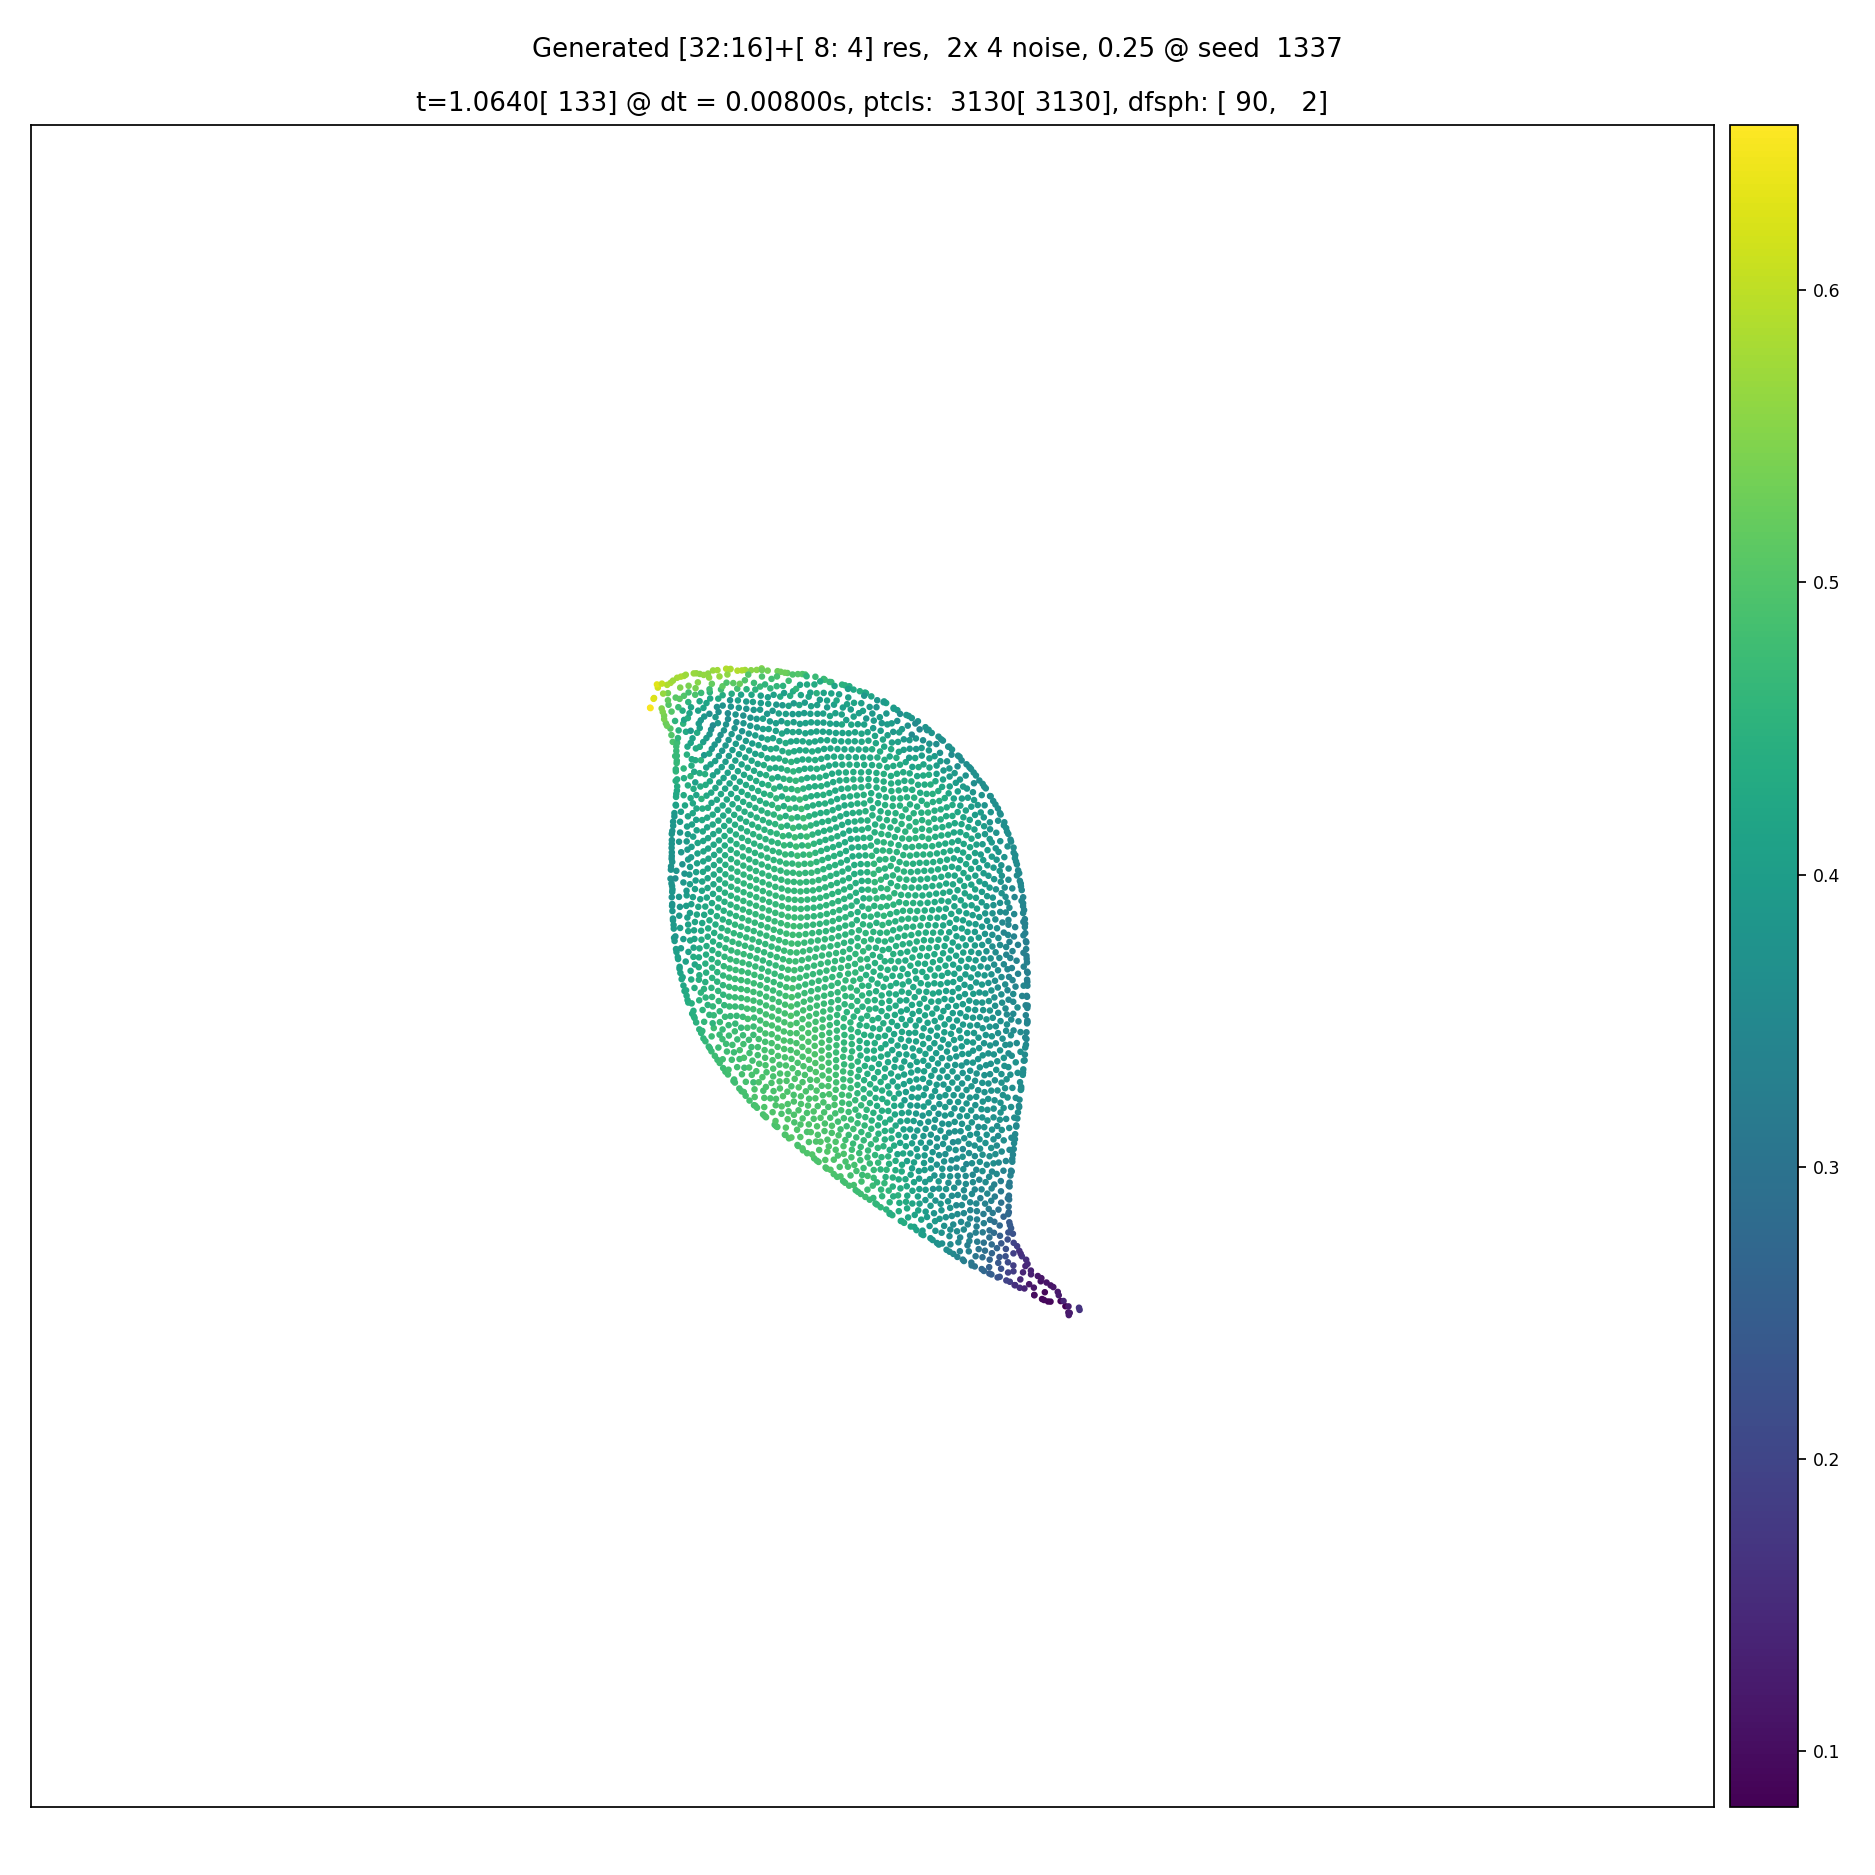

In [170]:
sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryFilterNeighborhoods(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryNeighborhoodSearch(sphSimulation.simulationState, sphSimulation)

sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)    
sphSimulation.boundaryModule.evalBoundaryDensity(sphSimulation.simulationState, sphSimulation) 
sphSimulation.simulationState['fluidAcceleration'] = torch.zeros_like(sphSimulation.simulationState['fluidVelocity'])   
sphSimulation.gravityModule.evaluate(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['densityIterations'] = sphSimulation.DFSPH.incompressibleSolver(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['fluidAcceleration'] += sphSimulation.simulationState['fluidPredAccel']
sphSimulation.velocityDiffusionModule.evaluate(sphSimulation.simulationState, sphSimulation)    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()


In [171]:
# print(sphSimulation.config['fluid'])

In [172]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './outputCollision/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [174]:
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 1 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

#         positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

  0%|          | 0/128 [00:00<?, ?it/s]

In [151]:
from src.modules.densityDiffusion import computeNormalizationMatrix
from src.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [171]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [169]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

torch.Size([286984, 9])
tensor([[[ 2.0370e+00, -1.1060e-02, -0.0000e+00],
         [-1.1061e-02,  2.0291e+00, -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
         [-1.1061e-02,  2.0291e+00, -4.4629e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  6.0596e+03],
         [-1.1061e-02,  2.0291e+00,  2.3369e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 8.5401e-01,  1.2634e-01, -1.9500e-03],
         [ 1.2634e-01,  1.1822e+00, -1.5179e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.5401e-01,  1.2634e-01, -2.3994e+00],
         [ 1.2634e-01,  1.1822e+00, -1.7218e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
    

In [99]:
batch_gj_solve(temp, n, 1, res)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [172]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

torch.Size([286984, 9])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [-1.1061e-02,  2.0291e+00, -4.4629e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [ 0.0000e+00,  2.0291e+00,  2.6662e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [213]:
normalizationMatrix.device

device(type='cuda', index=0)

In [253]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [254]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [256]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [192]:
print(m[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [155]:
print(temp[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [93]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


tensor([[ 2.0370, -0.0111],
        [-0.0111,  2.0291]], device='cuda:0')
tensor([[0.4909, 0.0027],
        [0.0027, 0.4928]], device='cuda:0')
tensor([[ 1.0000e+00, -2.9597e-05],
        [-2.9599e-05,  1.0000e+00]], device='cuda:0')
tensor([13129.4355,   -44.6293], device='cuda:0')
tensor([6445.4526,   13.1392], device='cuda:0')


In [23]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [151]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [11]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [104]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.66%       2.732ms        98.52%     404.890ms     404.890ms          -4 b        -284 b       1.51 Mb     -76.14 Mb             1  
                                  9 - density diffusion         0.06%     237.000us        35.73%     146.846ms      36.712ms         -16 b        -548 b     855.50 Kb           0 b             4  
         